In [1]:
# text_clustering based on CURE

import glob
import os
import shutil

import matplotlib.pyplot as plt
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.cure import cure
from pyclustering.utils import read_sample
from pyclustering.utils import timedcall
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode
from sklearn.datasets import load_files
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
spark = SparkSession.builder.appName("Python Spark CURE Clustering").getOrCreate()

In [3]:
def get_cluster_datapoints(file, number_clusters, number_represent_points, compression, ccore_flag):
    sample = read_sample(file)
    cure_instance = cure(sample, number_clusters, number_represent_points, compression, ccore_flag)
    (ticks, _) = timedcall(cure_instance.process)
    clusters = cure_instance.get_clusters()
    representors = cure_instance.get_representors()
    means = cure_instance.get_means()
    return sample, clusters, representors, means, ticks

In [4]:
def template_clustering(number_clusters, path, number_represent_points=10, compression=0.5, draw=True, ccore_flag=True, counter=0):
    cluster_files = glob.glob(path + "/*.csv")
    for c_file in cluster_files:
        sample, clusters, representors, means, ticks = get_cluster_datapoints(c_file, number_clusters, number_represent_points, compression, ccore_flag)
        final = open('final_cluster.txt', 'a+')
        final.write(str(representors).replace('], ', '\n').replace('[', '').replace(']', '').replace(',', '') + '\n')
        final.close()
    if counter % 1 == 0:
        number_clusters = 7
        number_represent_points = 10
        sample, clusters, representors, means, ticks = get_cluster_datapoints('final_cluster.txt', number_clusters, number_represent_points, compression, ccore_flag)
        final = open('final_cluster.txt', 'w+')
        final.write(str(representors).replace('], ', '\n').replace('[', '').replace(']', '').replace(',', '') + '\n')
        print("Cluster Dir: ", path, "\t\tExecution time: ", ticks, "\n")
        if draw is True:
            visualizer = cluster_visualizer()
            visualizer.append_clusters(clusters, sample)
            for cluster_index in range(len(clusters)):
                visualizer.append_cluster_attribute(0, cluster_index, representors[cluster_index], '*', 10)
                visualizer.append_cluster_attribute(0, cluster_index, [means[cluster_index]], 'o')
#             visualizer.save('fig' + str(counter) + '.png')
            visualizer.show()
            plt.close()

processing: csv_data/pubmed21n0060/

Cluster Dir:  cluster 		Execution time:  0.2331302911043167 



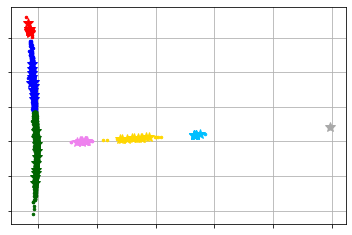

processing: csv_data/pubmed21n0067/

Cluster Dir:  cluster 		Execution time:  0.23703973600640893 



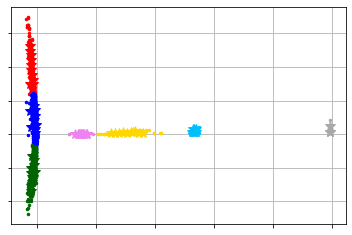

processing: csv_data/pubmed21n0069/

Cluster Dir:  cluster 		Execution time:  0.21579530404414982 



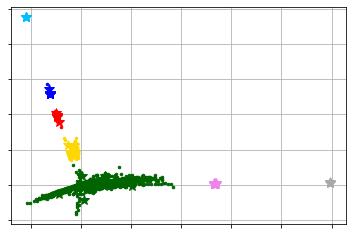

processing: csv_data/pubmed21n0015/

Cluster Dir:  cluster 		Execution time:  0.20403525803703815 



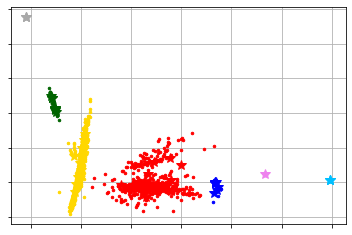

processing: csv_data/pubmed21n0012/

Cluster Dir:  cluster 		Execution time:  0.18104499392211437 



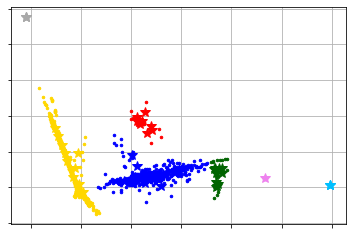

processing: csv_data/pubmed21n0027/

Cluster Dir:  cluster 		Execution time:  0.18171903700567782 



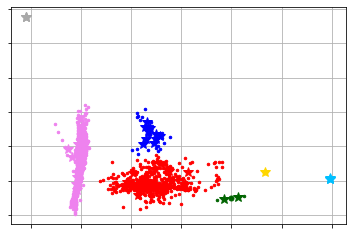

processing: csv_data/pubmed21n0020/

Cluster Dir:  cluster 		Execution time:  0.19211296900175512 



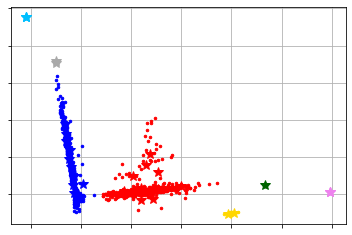

processing: csv_data/pubmed21n0052/

Cluster Dir:  cluster 		Execution time:  0.18310022098012269 



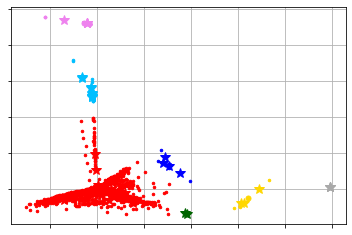

processing: csv_data/pubmed21n0029/

Cluster Dir:  cluster 		Execution time:  0.20185539592057467 



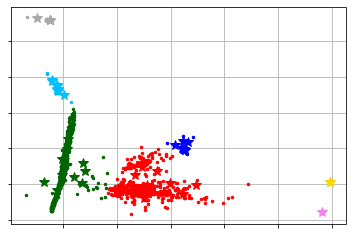

processing: csv_data/pubmed21n0055/

Cluster Dir:  cluster 		Execution time:  0.1761158478911966 



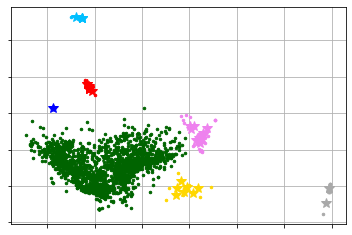

processing: csv_data/pubmed21n0038/

Cluster Dir:  cluster 		Execution time:  0.16691966098733246 



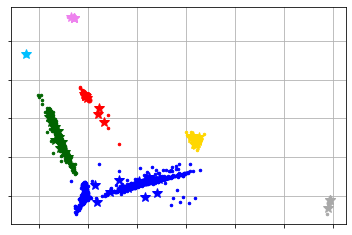

processing: csv_data/pubmed21n0044/

Cluster Dir:  cluster 		Execution time:  0.1829522419720888 



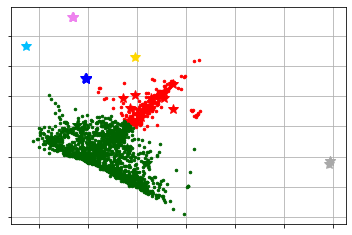

processing: csv_data/pubmed21n0043/


KeyboardInterrupt: 

In [5]:
if __name__ == '__main__':
    files = glob.glob("csv_data/*.csv")
    counter = 0
    for file in files:
        filepath = file.split('.')[0] + '/'
        print('processing: ' + filepath)
        df = spark.read.format("com.databricks.spark.csv").option("header", "true").option("delimiter", ",").option("inferSchema", "true").load(file)
        df = df.na.drop(subset=["pub_types", "article_title"])
        categories = [i.pub_types for i in df.select('pub_types').distinct().collect()]
        for cat in categories:
            path = filepath + cat
            df_temp = df.filter(df.pub_types == cat)
            df_temp.select('article_title').write.option('maxRecordsPerFile', 20000).csv(path)
        random_state = 0
        data = load_files(filepath, encoding="utf-8", decode_error="replace", random_state=random_state)
        data_target = [x.item() for x in data['target']]
        df = spark.createDataFrame(zip(data['data'], data_target), schema=['text', 'label'])
        df = df.withColumn('text', explode(split('text', '\n')))
        vec = TfidfVectorizer(stop_words="english")
        txt_values = [i.text for i in df.select('text').collect()]
        df = None
        vec.fit(txt_values)
        features = vec.transform(txt_values)
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features.toarray())
        dd = spark.createDataFrame(zip([x.item() for x in reduced_features[:, 0]], [x.item() for x in reduced_features[:, 1]]), schema=['x', 'y'])
        dd.write.option('maxRecordsPerFile', 30000).option("delimiter", " ").csv('cluster')
        dd = None
        counter += 1
        print('')
        template_clustering(7, 'cluster', 5, 0.5, counter=counter)
        isExist = os.path.exists('cluster')
        if isExist:
            shutil.rmtree('cluster')